In [1]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 1.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 KB 13.5 MB/s eta 0:00:00
  

In [2]:
#!python --version

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#!pip list

In [5]:
from gensim.models import KeyedVectors
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
import pycaret
import numpy as np
import pandas as pd
#For Classification
from pycaret.classification import *

pd.options.display.max_colwidth = None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
df_train = pd.read_csv('/content/drive/MyDrive/CapstoneData/amazon_review_polarity_csv/train_clean_20000.csv')
df_test = pd.read_csv('/content/drive/MyDrive/CapstoneData/amazon_review_polarity_csv/test_clean_4000.csv')
data = df_train.append(df_test, ignore_index=True)
data 

,label,title+review_clean
0,1,stun even nongamer sound track beautiful paint senery mind well would recomend even people hate vid game music play game chrono cross game ever play best music back away crude keyboarding take fresher step grate guitars soulful orchestras would impress anyone care listen _
1,1,best soundtrack ever anything read lot review say best game soundtrack figure id write review disagree bite opinino yasunori mitsudas ultimate masterpiece music timeless listen years beauty simply refuse fadethe price tag pretty stagger must say go buy cd much money one feel would worth every penny
2,1,amaze soundtrack favorite music time hand intense sadness prisoners fate mean play game hope distant promise girl steal star important inspiration personally throughout teen years higher energy track like chrono cross time scar time dreamwatch chronomantique indefinably remeniscent chrono trigger absolutely superb wellthis soundtrack amaze music probably best composers work not hear xenogears soundtrack cannot say sure even never play game would worth twice price buy iti wish could give star
3,1,excellent soundtrack truly like soundtrack enjoy video game music play game music enjoy truly relax peacefulon disk one favorites scar time life death forest illusion fortress ancient dragons lose fragment drown valleydisk two draggons galdorb home chronomantique prisoners fate gale girlfriend like zelbessdisk three best three garden god chronopolis fat jellyfish sea burn orphange dragons prayer tower star dragon god radical dreamers unstealable jeweloverall excellent soundtrack bring like video game musicxander cross
4,1,remember pull jaw floor hear play game know divine music every single song tell story game good greatest songs without doubt chrono cross time scar magical dreamers wind star sea radical dreamers unstolen jewel translation vary music perfect ask best yasunori mitsuda pour heart write paper
...,...,...
23995,0,poor product faulty units right box first would not hold charge couple days not improve cycle battery number time return replacement nd unit never indicate full charge even charge several days move another branddont waste time money poor quality items
23996,1,chevrolet inline sixcylinder power manual find book informative easy understand look sometime information reguarding chevrolet inline six cylinders really help knowledge unstanding inline six cylinder motor find inpressive highly underated small block v chevy motor head wish could find book long finish build motor ok already plan next motor refer book build torque horsepower
23997,1,true story st stag struggle free soviet jews history outline jdl ideology read every jewwhether agree kahaneread especially say jabotinsky
23998,1,nut not book library one finest book hollywoods master photographer george hurrell author not expert right know hurrell special blend along fact author know write choose wonderful never see photos make book one satisfy bedtime meal great read


In [7]:
#different word embeddings

#fasttext_crawl_300 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/CapstoneModels/crawl-300d-2M.vec')
#fasttext_wiki_300 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/CapstoneModels/wiki-news-300d-1M.vec')
glove_6B_300 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/CapstoneModels/glove.6B.300d.txt', binary=False, no_header=True)#,limit=500000) 
#glove_42B_300 = KeyedVectors.load_word2vec_format('/content/drive/MyDrive/CapstoneModels/glove.6B.300d.txt', binary=False, no_header=True)#,limit=500000)

word_embed = glove_6B_300
n = 300

In [8]:
df_train['title+review_clean_list'] = df_train['title+review_clean'].apply(word_tokenize)
df_test['title+review_clean_list'] = df_test['title+review_clean'].apply(word_tokenize)

In [9]:
def get_mean_vector(model, words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in model.key_to_index]
    if len(words) >= 1:
        return np.mean(model[words], axis=0)
    else:
        return []

In [10]:
df_train['mean_vector'] = df_train['title+review_clean_list'].apply(lambda x: get_mean_vector(word_embed, x))
df_test['mean_vector'] = df_test['title+review_clean_list'].apply(lambda x: get_mean_vector(word_embed, x))

In [11]:
X_train = np.vstack(df_train['mean_vector'])
X_test = np.vstack(df_test['mean_vector'])
df_train_word_embed = pd.DataFrame(X_train)
df_test_word_embed = pd.DataFrame(X_test)

df_train_word_embed['label'] = df_train['label']
df_test_word_embed['label'] = df_test['label']

In [12]:
s = setup(df_train_word_embed, target = 'label', session_id = 123)

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Binary
3,Original data shape,"(20000, 301)"
4,Transformed data shape,"(20000, 301)"
5,Transformed train set shape,"(14000, 301)"
6,Transformed test set shape,"(6000, 301)"
7,Numeric features,300
8,Preprocess,True
9,Imputation type,simple


In [13]:
top_3 = compare_models(n_select = 3)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.8229,0.9012,0.8169,0.8344,0.8254,0.6458,0.6461,1.8370
lr,Logistic Regression,0.8221,0.9002,0.8202,0.8307,0.8254,0.6440,0.6441,1.6340
ridge,Ridge Classifier,0.8214,0.0000,0.8127,0.8348,0.8235,0.6429,0.6433,0.2590
svm,SVM - Linear Kernel,0.8179,0.0000,0.7929,0.8447,0.8165,0.6362,0.6395,0.8290
xgboost,Extreme Gradient Boosting,0.8115,0.8910,0.8180,0.8152,0.8166,0.6227,0.6228,92.4000
lightgbm,Light Gradient Boosting Machine,0.8105,0.8938,0.8175,0.8139,0.8156,0.6207,0.6209,8.7020
gbc,Gradient Boosting Classifier,0.7960,0.8786,0.7989,0.8027,0.8006,0.5918,0.5920,129.8610
et,Extra Trees Classifier,0.7819,0.8619,0.7868,0.7878,0.7872,0.5634,0.5636,6.2220
rf,Random Forest Classifier,0.7809,0.8613,0.7939,0.7824,0.7879,0.5614,0.5617,20.1990
ada,Ada Boost Classifier,0.7654,0.8472,0.7692,0.7726,0.7707,0.5305,0.5307,25.9010


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

In [17]:
top_3

[LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                            priors=None, shrinkage=None, solver='svd',
                            store_covariance=False, tol=0.0001),
 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                 max_iter=None, positive=False, random_state=123, solver='auto',
                 tol=0.0001)]

In [26]:
pred = [predict_model(i, data=df_test_word_embed) for i in top_3]


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.8225,0.9019,0.8243,0.8283,0.8263,0.6448,0.6448


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8170,0.8998,0.8233,0.8201,0.8217,0.6337,0.6337


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8192,0.8192,0.8209,0.8253,0.8231,0.6383,0.6383


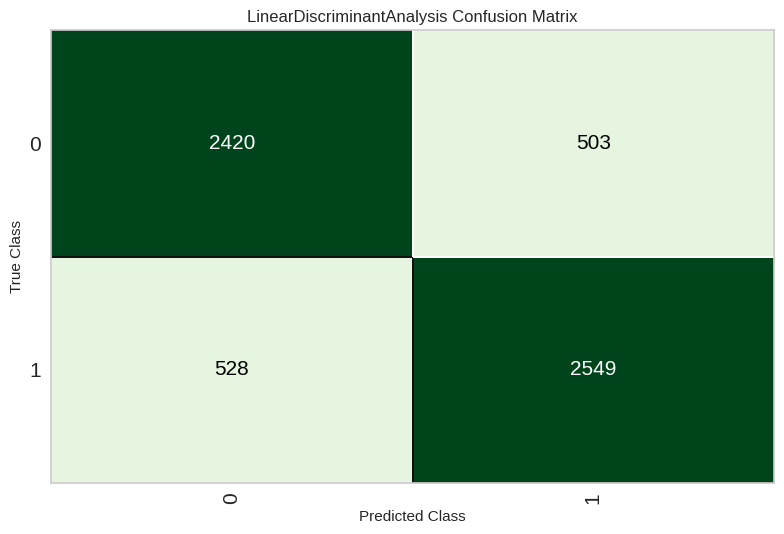

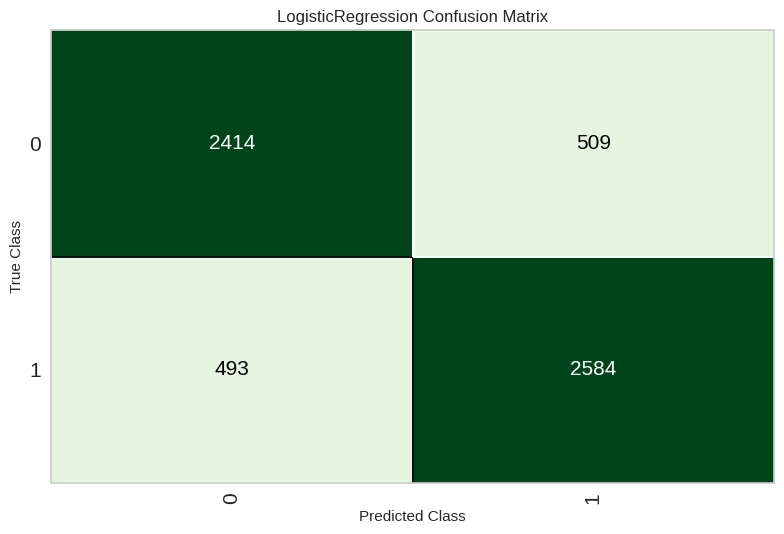

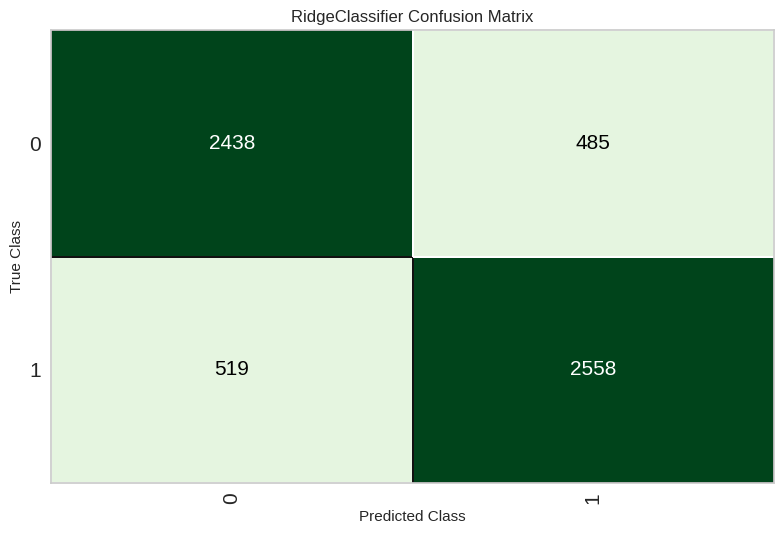

[None, None, None]

In [33]:
# plot confusion matrix
[plot_model(i, plot = 'confusion_matrix') for i in top_3]

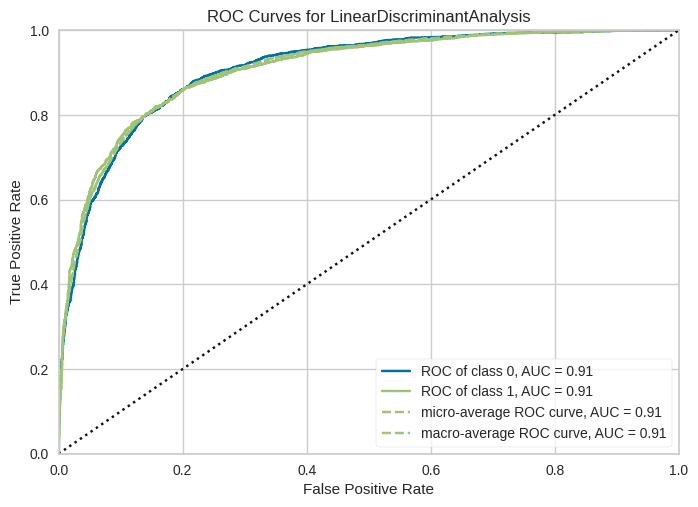

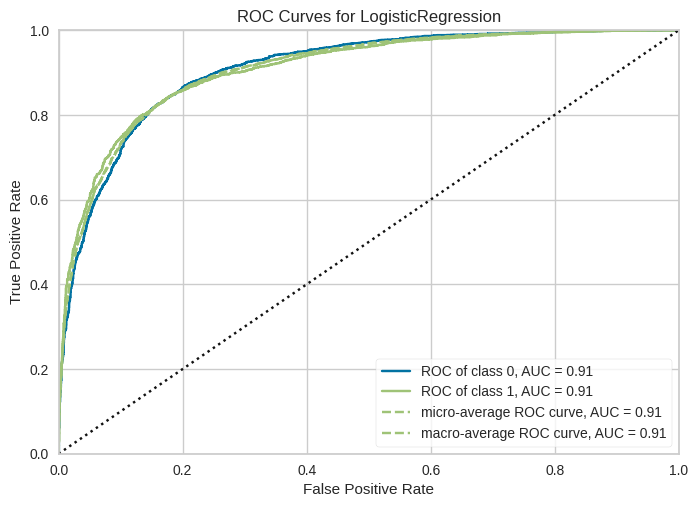

TypeError: ignored

In [37]:
# plot auc
[plot_model(i, plot = 'auc') for i in top_3]

In [36]:
tuned_top_3 = [tune_model(i) for i in top_3] 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8136,0.8963,0.7827,0.8426,0.8116,0.6276,0.6293
1,0.8271,0.9124,0.8343,0.8296,0.8319,0.6540,0.6540
2,0.8143,0.8979,0.7925,0.8368,0.8140,0.6288,0.6298
3,0.8300,0.9083,0.8259,0.8399,0.8329,0.6599,0.6600
4,0.8186,0.8969,0.8134,0.8295,0.8214,0.6371,0.6372
5,0.8321,0.9082,0.8273,0.8426,0.8349,0.6642,0.6643
6,0.8200,0.8868,0.8134,0.8319,0.8225,0.6400,0.6401
7,0.8264,0.9088,0.8301,0.8312,0.8307,0.6526,0.6526
8,0.8121,0.8985,0.7953,0.8311,0.8128,0.6245,0.6251


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8086,0.8971,0.7855,0.8319,0.8080,0.6175,0.6185
1,0.8307,0.9121,0.8454,0.8281,0.8367,0.6610,0.6612
2,0.8193,0.8977,0.8064,0.8355,0.8207,0.6387,0.6391
3,0.8236,0.9093,0.8301,0.8266,0.8284,0.6469,0.6469
4,0.8221,0.8963,0.8162,0.8336,0.8248,0.6442,0.6444
5,0.8307,0.9092,0.8315,0.8373,0.8344,0.6613,0.6613
6,0.8236,0.8876,0.8231,0.8312,0.8272,0.6470,0.6470
7,0.8293,0.9093,0.8370,0.8313,0.8341,0.6583,0.6583
8,0.8200,0.8991,0.8134,0.8319,0.8225,0.6400,0.6401


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8121,0.0000,0.7841,0.8390,0.8107,0.6247,0.6261
1,0.8307,0.0000,0.8357,0.8345,0.8351,0.6612,0.6612
2,0.8171,0.0000,0.8036,0.8338,0.8184,0.6344,0.6348
3,0.8286,0.0000,0.8203,0.8414,0.8307,0.6571,0.6574
4,0.8200,0.0000,0.8106,0.8338,0.8220,0.6400,0.6403
5,0.8350,0.0000,0.8259,0.8484,0.8370,0.6700,0.6703
6,0.8164,0.0000,0.8092,0.8288,0.8189,0.6328,0.6330
7,0.8221,0.0000,0.8203,0.8307,0.8255,0.6442,0.6442
8,0.8143,0.0000,0.8008,0.8309,0.8156,0.6287,0.6291


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [38]:
tuned_top_3

[LinearDiscriminantAnalysis(covariance_estimator=None, n_components=None,
                            priors=None, shrinkage=None, solver='svd',
                            store_covariance=False, tol=0.0001),
 LogisticRegression(C=7.689, class_weight={}, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=1000,
                    multi_class='auto', n_jobs=None, penalty='l2',
                    random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                    warm_start=False),
 RidgeClassifier(alpha=7.68, class_weight=None, copy_X=True, fit_intercept=True,
                 max_iter=None, positive=False, random_state=123, solver='auto',
                 tol=0.0001)]

In [39]:
tuned_pred = [predict_model(i, data=df_test_word_embed) for i in tuned_top_3]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.8225,0.9019,0.8243,0.8283,0.8263,0.6448,0.6448


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.8178,0.9017,0.8272,0.8188,0.8230,0.6352,0.6352


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8172,0.8173,0.8170,0.8246,0.8208,0.6344,0.6344


In [ ]:
#evaluate_model(top_3[0])

In [49]:
save_model(top_3[0], 'glove_6B_300_top1')
save_model(top_3[1], 'glove_6B_300_top2')
save_model(top_3[2], 'glove_6B_300_top3')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=/tmp/joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['0', '1', '2', '3', '4', '5', '6',
                                              '7', '8', '9', '10', '11', '12',
                                              '13', '14', '15', '16', '17', '18',
                                              '19', '20', '21', '22', '23', '24',
                                              '25', '26', '27', '28', '29', ...],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_feat...
                  TransformerWrapper(exclude=None, include=[],
                                     transformer=SimpleImputer(add_ind

In [50]:
load_model('glove_6B_300_top1')

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=/tmp/joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['0', '1', '2', '3', '4', '5', '6',
                                             '7', '8', '9', '10', '11', '12',
                                             '13', '14', '15', '16', '17', '18',
                                             '19', '20', '21', '22', '23', '24',
                                             '25', '26', '27', '28', '29', ...],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_feat...
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent',
                                                              verbose='deprecated'))),
                ('trained_model',
                 LinearDiscriminantAnalysis(covariance_estimator=None,
                                            n_components=None, priors=None,
                                            shrinkage=None, solver='svd',
                                            store_covariance=False,
                                            tol=0.0001))],
         verbose=False)